In [1]:
def resolve_timestamp(ts):
    actual = ts + (2 ** 32) if ts < 0 else ts
    seconds = actual / 1e6  # Convert from nanoseconds to seconds
    return actual, seconds

ts = -1491731364
actual, secs = resolve_timestamp(ts)
print(f"Original: {ts}")
print(f"Actual nanoseconds: {actual}")
print(f"Seconds: {secs}")

Original: -1491731364
Actual nanoseconds: 2803235932
Seconds: 2803.235932


In [72]:
!gdown 1CY3cuXUbrpPQsxbULtnT-UsPOUPWzaRT
!gdown 1PQC79uI6ATuwh0ehNxcdWwyyyOKklTLc

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading...
From: https://drive.google.com/uc?id=1CY3cuXUbrpPQsxbULtnT-UsPOUPWzaRT
To: /Users/davidledbetter/RAG_Practice/outputs3.log
100%|██████████████████████████████████████| 71.3M/71.3M [00:01<00:00, 36.7MB/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading...
From (original): https://drive.google.com/uc?id=1PQC79uI6ATuwh0ehNxcdWwyyyOKklTLc
From (redirected): https://drive.google.com/uc?id=1PQC79uI6ATuwh0ehNxcdWwyyyOKklTLc&confirm=t&uuid=7424808e-e405-43ee-b272-658416e915df
To: /Users/davidledbetter/RAG_Practice/embeddings_870000.npy
100%|██████████████████████████████████████| 1.34G/1.34G [00:34<00:00, 38.9MB/s]


In [2]:
!head outputs3.log
!head syscalls.txt

[739690039] PID: 334, Comm: systemd-journal, Syscall: openat, Path: /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa, Flags: 526338
[739981084] PID: 334, Comm: systemd-journal, Syscall: openat, Path: /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa, Flags: 526338
[739998582] PID: 334, Comm: systemd-journal, Syscall: openat complete, Path: /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa, FD: -2
[740059399] PID: 334, Comm: systemd-journal, Syscall: openat, Path: /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa, Flags: 526338
[740070511] PID: 334, Comm: systemd-journal, Syscall: openat complete, Path: /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa, FD: -2
[740195430] PID: 334, Comm: systemd-journal, Syscall: openat, Path: /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa, Flags: 526338
[740207788] PID: 334, Comm: systemd-journal, Syscall: openat complete, Path: /run/log/journal/7e5f3214b7034fa48fbc

In [66]:
!wc -l outputs3.log

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  882384 outputs3.log


In [4]:
from os import times
import os
import pandas as pd
import itertools
from tqdm import tqdm

f = open('syscalls.txt', 'r')
x86_64_syscalls = f.read()
f.close()

def parse_syscall_table(table):
    syscall_vocab = {}
    for i, line in enumerate(table.strip().split("\n")):
        parts = line.split("\t")
        index = int(parts[0])  # Syscall index
        name = parts[1]        # Syscall name
        syscall_vocab[name] = i
    return syscall_vocab

syscall_vocab = parse_syscall_table(x86_64_syscalls)
print(f"syscall vocab size is {len(syscall_vocab)}")
print(syscall_vocab)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def preprocess_flow_file(file_path):
    data = []
    line_count = int(os.popen(f'wc -l {file_path}').read().split()[0])
    with open(file_path, 'r') as file:
        for line in tqdm(file, desc="Processing lines", total=line_count):
            if line.startswith("Lost"):
                continue
            try:
                # Parse new format: [-1491731364] PID: 334, Comm: systemd-journal, Syscall: openat...
                parts = line.strip().split(", ")
                timestamp_pid = parts[0].split(" PID: ")
                timestamp = int(timestamp_pid[0].strip("[]"))
                _, timestamp = resolve_timestamp(timestamp)
                pid = int(timestamp_pid[1])
                
                if "PPID:" in line:
                    # Parse fork event
                    ppid = int(parts[1].split(": ")[1])
                    comm = parts[2].split(": ")[1]
                    child_comm = parts[3].split(": ")[1]
                    
                    data.append({
                        "Timestamp": timestamp,
                        "PID": pid,
                        "PPID": ppid,
                        "Comm": comm.lower(),
                        "Child_comm": child_comm.lower(),
                        "Event_type": "fork"
                    })
                else:
                    # Parse regular syscall
                    comm = parts[1].split(": ")[1]
                    syscall = parts[2].split(": ")[1]
                    args = {p.split(": ")[0].lower(): p.split(": ")[1] for p in parts[3:]}
                    
                    data.append({
                        "Timestamp": timestamp,
                        "PID": pid,
                        "Comm": comm.lower(),
                        "Syscall": syscall.lower(),
                        "Args": args,
                        "Event_type": "syscall"
                    })
            except Exception as e:
                print(f"Error processing line: {line.strip()}")
                print(f"Error: {e}")
    
    return pd.DataFrame(data)

flow_file_path = "outputs3.log"
flow_data = preprocess_flow_file(flow_file_path)
# flow_data.head(5000)

syscall vocab size is 361
{'read': 0, 'write': 1, 'open': 2, 'close': 3, 'stat': 4, 'fstat': 5, 'lstat': 6, 'poll': 7, 'lseek': 8, 'mmap': 9, 'mprotect': 10, 'munmap': 11, 'brk': 12, 'rt_sigaction': 13, 'rt_sigprocmask': 14, 'rt_sigreturn': 15, 'ioctl': 16, 'pread': 17, 'pwrite': 18, 'readv': 19, 'writev': 20, 'access': 21, 'pipe': 22, 'select': 23, 'sched_yield': 24, 'mremap': 25, 'msync': 26, 'mincore': 27, 'madvise': 28, 'shmget': 29, 'shmat': 30, 'shmctl': 31, 'dup': 32, 'dup2': 33, 'pause': 34, 'nanosleep': 35, 'getitimer': 36, 'alarm': 37, 'setitimer': 38, 'getpid': 39, 'sendfile': 40, 'socket': 41, 'connect': 42, 'accept': 43, 'sendto': 44, 'recvfrom': 45, 'sendmsg': 46, 'recvmsg': 47, 'shutdown': 48, 'bind': 49, 'listen': 50, 'getsockname': 51, 'getpeername': 52, 'socketpair': 53, 'setsockopt': 54, 'getsockopt': 55, 'clone': 56, 'fork': 57, 'vfork': 58, 'execve': 59, 'exit': 60, 'wait4': 61, 'kill': 62, 'uname': 63, 'semget': 64, 'semop': 65, 'semctl': 66, 'shmdt': 67, 'msgget'

Processing lines: 882385it [00:02, 358875.44it/s]                            


In [5]:
import torch
import matplotlib.pyplot as plt
import networkx as nx

class HeteroDynamicGraph:
    def __init__(self, max_connections=None):
        from collections import deque
        self.deque = deque
        self.node_types = {}  # Node types: {node_type: {name: tensor([embedding])}}
        self.edge_types = {}  # Edge types: {(src_type, edge_type, dst_type): {src: {dst: tensor([embedding])}}}
        self.connections = {}  # {(node_type, name): deque()} to track connections per node
        self.nodes = {} # {node_type: deque()} to track nodes per node type

        # Default max connections per node type
        self.max_connections = max_connections or {
            "Syscall": {
                "mmap": 100,
                "default": 1000
            },
            "PID": {
                "default": 1500
            },
            "default": 500
        }

    def add_node(self, node_type, name, features):
        """
        Args:
            node_type: Type of node (e.g., 'PID', 'Syscall', 'FD', etc.)
            name: Unique identifier for the node
            features: Tensor of features, will prepend degree
        """
        if node_type not in self.node_types:
            self.node_types[node_type] = {}
            
        if name in self.node_types[node_type]:
            return
        
        if node_type not in self.nodes:
            self.nodes[node_type] = self.deque()
        
        self.nodes[node_type].append(name)
            
        self.node_types[node_type][name] = features
        

    # Add an edge
    def add_edge(self, src_type, src, edge_type, dst_type, dst, embedding=None):
        if src_type not in self.node_types or dst_type not in self.node_types:
            raise ValueError(f"Both source type {src_type} and destination type {dst_type} must exist.")
        if src not in self.node_types[src_type] or dst not in self.node_types[dst_type]:
            raise ValueError(f"Both source node {src} and destination node {dst} must exist.")
        
        # manage connections queue
        ############################################################
        node_key = (src_type, src)
        if node_key not in self.connections:
            self.connections[node_key] = self.deque()
        
        max_conns = (self.max_connections.get(src_type, {})
                    .get(src, self.max_connections.get(src_type, {})
                    .get('default', self.max_connections['default'])))

        # Add new connection to queue
        self.connections[node_key].append((edge_type, dst_type, dst))

        if len(self.connections[node_key]) > max_conns:
            old_edge_type, old_dst_type, old_dst = self.connections[node_key].popleft()
            self.delete_edge(src_type, src, old_edge_type, old_dst_type, old_dst)

        # manage edge types
        ############################################################
        edge_key = (src_type, edge_type, dst_type)
        if edge_key not in self.edge_types:
            self.edge_types[edge_key] = {}
        
        if src not in self.edge_types[edge_key]:
            self.edge_types[edge_key][src] = {}

        # Store both weight and features
        edge_data = {
            'embedding': embedding if embedding is not None else torch.tensor([0.0])
        }

        self.edge_types[edge_key][src][dst] = edge_data

    def delete_node(self, node_type, name):
        """
        Delete a node and update degrees of connected nodes.
        
        Args:
            node_type: Type of node to remove
            name: Identifier of the node
        """
        if node_type not in self.node_types or name not in self.node_types[node_type]:
            raise ValueError(f"Node {name} does not exist in type {node_type}.")

        del self.node_types[node_type][name]

        # Remove all edges involving this node
        for edge_key, connections in list(self.edge_types.items()):
            if edge_key[0] == node_type:  # Source type
                connections.pop(name, None)
            if edge_key[2] == node_type:  # Destination type
                for neighbors in connections.values():
                    neighbors.pop(name, None)

    # Delete an edge
    def delete_edge(self, src_type, src, edge_type, dst_type, dst):
        edge_key = (src_type, edge_type, dst_type)
        if edge_key in self.edge_types and src in self.edge_types[edge_key]:
            self.edge_types[edge_key][src].pop(dst, None)
            if not self.edge_types[edge_key][src]:
                del self.edge_types[edge_key][src]

    # Get neighbors
    def get_neighbors(self, node_type, name, edge_type=None):
        neighbors = {}
        for edge_key, connections in self.edge_types.items():
            if edge_key[0] == node_type and name in connections:  # Outgoing edges
                if edge_type is None or edge_key[1] == edge_type:
                    neighbors[edge_key] = connections[name]
        return neighbors

    # def extract_subgraph(self, node_type_subset):
    #     subgraph = HeteroDynamicGraph(is_directed=self.is_directed)
    #     for node_type, node_names in node_type_subset.items():
    #         if node_type in self.node_types:
    #             for name in node_names:
    #                 if name in self.node_types[node_type]:
    #                     subgraph.add_node(node_type, name, self.node_types[node_type][name])
    #     for edge_key, connections in self.edge_types.items():
    #         src_type, edge_type, dst_type = edge_key
    #         if src_type in node_type_subset and dst_type in node_type_subset:
    #             for src, neighbors in connections.items():
    #                 if src in node_type_subset[src_type]:
    #                     for dst in neighbors:
    #                         if dst in node_type_subset[dst_type]:
    #                             subgraph.add_edge(src_type, src, edge_type, dst_type, dst, neighbors[dst])
    #     return subgraph

    # def to_torch(self, device="cpu"):
    #     tensors = {}
    #     for edge_key, connections in self.edge_types.items():
    #         src_type, edge_type, dst_type = edge_key
    #         src_list = []
    #         dst_list = []
    #         weights = []
    #         for src, neighbors in connections.items():
    #             for dst, weight in neighbors.items():
    #                 src_idx = list(self.node_types[src_type].keys()).index(src)
    #                 dst_idx = list(self.node_types[dst_type].keys()).index(dst)
    #                 src_list.append(src_idx)
    #                 dst_list.append(dst_idx)
    #                 weights.append(weight)
    #         tensors[edge_key] = {
    #             'edge_index': torch.tensor([src_list, dst_list], device=device),
    #             'edge_weights': torch.tensor(weights, device=device)
    #         }
    #     return tensors

    def to_heterodata(self):
        from torch_geometric.data import HeteroData
        data = HeteroData()

        # Add nodes and their features
        for node_type, nodes in self.node_types.items():
            data[node_type].x = torch.stack(list(nodes.values()))

        # Add edges and edge features
        for (src_type, edge_type, dst_type), connections in self.edge_types.items():
            edge_index = []
            edge_features = []
            for src, neighbors in connections.items():
                for dst, edge_data in neighbors.items():
                    src_idx = list(self.node_types[src_type].keys()).index(src)
                    dst_idx = list(self.node_types[dst_type].keys()).index(dst)
                    edge_index.append([src_idx, dst_idx])

                    # print("Edge embedding shape before:", edge_data['embedding'].shape)
                    embedding = edge_data['embedding']
                    if embedding.dim() == 1:
                        embedding = embedding.unsqueeze(0)
                    # print("Edge embedding shape after:", embedding.shape)
                    edge_features.append(embedding)


            if edge_index:  # Check if there are any edges
                edge_index = torch.tensor(edge_index).t()
                edge_features = torch.cat(edge_features, dim=0)  # Concatenate edge embeddings

                data[(src_type, edge_type, dst_type)].edge_index = edge_index
                data[(src_type, edge_type, dst_type)].edge_attr = edge_features

        return data

    def from_heterodata(self, data):
        """Convert HeteroData to internal dictionary format."""
        # Handle nodes
        ############################################################
        self.node_types = {}
        for node_type in data.node_types:
            self.node_types[node_type] = {}
            for i in range(data[node_type].x.size(0)):
                self.node_types[node_type][i] = data[node_type].x[i]

        # Handle edges
        ############################################################
        self.edge_types = {}
        for edge_type in data.edge_types:
            src_type, edge_name, dst_type = edge_type
            edge_key = (src_type, edge_name, dst_type)
            self.edge_types[edge_key] = {}
            
            # Convert edge_index and edge_attr to dictionary format
            edge_index = data[edge_type].edge_index
            edge_attr = data[edge_type].edge_attr if hasattr(data[edge_type], 'edge_attr') else None
            
            for i in range(edge_index.size(1)):
                src = edge_index[0, i].item()
                dst = edge_index[1, i].item()
                embedding = edge_attr[i] if edge_attr is not None else torch.tensor([0.0])
                
                if src not in self.edge_types[edge_key]:
                    self.edge_types[edge_key][src] = {}
                self.edge_types[edge_key][src][dst] = embedding

        return self

    def visualize(self):
        g = nx.DiGraph()
        node_colors = []
        for node_type, nodes in self.node_types.items():
            for name in nodes:
                # print(f"{node_type}:{name}")
                if "arg_" in node_type.lower():
                    g.add_node(f"{node_type}:{name}")
                    node_colors.append("magenta")
                else:
                    if node_type == "PID":
                        node_colors.append("blue")
                    elif node_type == "Syscall":
                        node_colors.append("red")
                    elif node_type == "Comm":
                        node_colors.append("green")
                    else:
                        print("grey added")
                        node_colors.append("gray")
                    g.add_node(f"{node_type}:{name}")
        # node_colors.append("gray")
        for edge_key, connections in self.edge_types.items():
            src_type, edge_type, dst_type = edge_key
            for src, neighbors in connections.items():
                for dst, _ in neighbors.items():
                    g.add_edge(f"{src_type}:{src}", f"{dst_type}:{dst}", label=edge_type)
        plt.figure(figsize=(50, 40))
        pos = nx.spring_layout(g)
        nx.draw(g, pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=10)
        # edge_labels = nx.get_edge_attributes(g, "label")
        # nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)
        plt.show()

In [6]:
graph = HeteroDynamicGraph()
graph.add_node("Syscall", "open", torch.tensor([1.0, 2.0]))
graph.add_node("PID", "123", torch.tensor([0.5]))
graph.add_edge("Syscall", "open", "calls", "PID", "123", embedding=torch.tensor([0.8]))

# Convert to HeteroData
data = graph.to_heterodata()
print(data)

# Reconstruct the graph
new_graph = HeteroDynamicGraph().from_heterodata(data)
print(new_graph.node_types)
print(new_graph.edge_types)


HeteroData(
  Syscall={ x=[1, 2] },
  PID={ x=[1, 1] },
  (Syscall, calls, PID)={
    edge_index=[2, 1],
    edge_attr=[1, 1],
  }
)
{'Syscall': {0: tensor([1., 2.])}, 'PID': {0: tensor([0.5000])}}
{('Syscall', 'calls', 'PID'): {0: {0: tensor([0.8000])}}}


/Users/davidledbetter/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# from torch_geometric.data import HeteroData

# # Create a test HeteroData object
# data = HeteroData()
# data['PID'].x = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
# data['Syscall'].x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
# data[('Syscall', 'calls', 'PID')].edge_index = torch.tensor([[0, 1], [1, 0]])
# data[('Syscall', 'calls', 'PID')].edge_attr = torch.tensor([[0.5], [0.6]])

# # Convert to HeteroDynamicGraph and back
# graph = HeteroDynamicGraph()
# graph.from_heterodata(data)
# reconstructed_data = graph.to_heterodata()

# # Verify round-trip equivalence
# print(data)
# print(reconstructed_data)
# assert str(data) == str(reconstructed_data), "Round-trip conversion failed!"
# print("Round-trip conversion succeeded!")


In [8]:
!pip install sentence-transformers

In [9]:
def create_sliding_windows(data, window_size=300, step_size=150):
    """Create sliding windows with enhanced syscall information"""
    windows = []
    
    for start_idx in tqdm(range(0, len(data) - window_size + 1, step_size), desc="Creating Sliding Windows"):
        window = data.iloc[start_idx:start_idx + window_size]
        windows.append(window)
    
    return windows

windows = create_sliding_windows(flow_data, window_size=3000, step_size=1500)

Creating Sliding Windows: 100%|██████████| 587/587 [00:00<00:00, 63239.92it/s]


In [10]:
def humanize_arg(arg_type, value, pid=None):
    """Convert argument types to more human-readable descriptions"""
    arg_descriptions = {
        'parent tid': f"parent thread {value}",
        'offset': f"at offset {value}",
        'msghdr': f"message header at {value}",
        'gid': f"group ID {value}",
        'old': f"old file path {value}",
        'mode': f"with permissions {value}",
        'prot': f"with protection flags {value}",
        'flags': f"with access flags {value}",
        'family': f"protocol family {value}",
        'path': f"file path {value}",
        'new': f"new file path {value}",
        'addrlen': f"address length {value}",
        'size': f"size {value} bytes",
        'protocol': f"using protocol {value}",
        'signal': f"signal {value}",
        'type': f"of type {value}",
        'count': f"count of {value}",
        'addr': f"at address {value}",
        'uid': f"user ID {value}",
        'fd': f"to or from {pid}'s file descriptor {value}",
        'length': f"length of {value}",
        'len': f"length {value}",
        'backlog': f"with backlog {value}",
        'target pid': f"targeting process {value}",
        'stack': f"stack at {value}",
        'how': f"with mode {value}",
        'resource': f"resource {value}"
    }
    return arg_descriptions.get(arg_type, f"{arg_type} {value}")

def parse_log_line(line):
    # print(f"parsing line: {line} ", end="")
    """Convert a log line into a natural language description with humanized arguments"""
    try:
        parts = line.split('] ')
        if len(parts) < 2:
            return None
            
        content = parts[1].strip()
        components = {}
        
        
        if "PID:" in content:
            pid = content.split("PID:")[1].split(',')[0].strip()
            components['pid'] = pid
        if "Comm:" in content:
            comm = content.split("Comm:")[1].split(',')[0].strip()
            components['comm'] = comm
        if "Syscall:" in content:
            syscall = content.split("Syscall:")[1].split(',')[0].strip()
            if "recv" in syscall:
                syscall = syscall.replace("recv", "receive")

            if "mmap" in syscall:
                syscall = syscall.replace("mmap", "memory map")

            if "chmod" in syscall:
                syscall = syscall.replace("chmod", "change mode")

            if "chown" in syscall:
                syscall = syscall.replace("chown", "change owner")

            if "chgrp" in syscall:
                syscall = syscall.replace("chgrp", "change group")
                
            if "msg" in syscall:
                syscall = syscall.replace("msg", "message")

            if "read" in syscall:
                syscall = syscall.replace("read", "read from")

            if "write" in syscall:
                syscall = syscall.replace("write", "write to")

            components['syscall'] = syscall

        
        if all(k in components for k in ['pid', 'comm', 'syscall']):
            desc = f"command ({components['comm']}) intializes process {components['pid']} and performs {components['syscall']}"
            
            # Extract and humanize all arguments
            args = []
            for arg_type in ['parent tid', 'offset', 'MSGHDR', 'gid', 'old', 'mode', 
                           'prot', 'flags', 'family', 'path', 'new', 'addrlen', 
                           'size', 'protocol', 'signal', 'type', 'count', 'addr', 
                           'uid', 'FD', 'length', 'len', 'backlog', 'target pid', 
                           'stack', 'how', 'resource']:
                arg_marker = f"{arg_type.title()}:"
                
                if arg_marker.lower() in content.lower():
                    # print(f"| arg_marker: {arg_marker.lower()}")
                    value = content.lower().split(arg_marker.lower())
                    # print(f"| value: {value}")
                    value = value[1].split(',')[0].strip()
                    # print(f"| value: {value}")
                    args.append(humanize_arg(arg_type.lower(), value, pid))
            
            if args:
                desc += " with " + ", ".join(args)
            
            # print(f"| parsed line: {desc}")
            return desc
            
    except Exception as e:
        print(f"Error parsing line: {e}")
        return None
"""[-1507869552] PID: 334, Comm: systemd-journal, Syscall: read, FD: 50, Count: 4104"""
"""[-1486342089] PID: 334, Comm: systemd-journal, Syscall: recvmsg, FD: 3, MSGHDR: 7ffee2c95310"""
# Example usage:
log_line = "[-1486342089] PID: 334, Comm: systemd-journal, Syscall: recvmsg, FD: 3, MSGHDR: 7ffee2c95310"
description = parse_log_line(log_line)
print(description)
# Output: "Process 334 (systemd-journal) performs read with file descriptor 50, count of 4104"

command (systemd-journal) intializes process 334 and performs receivemessage with message header at 7ffee2c95310, to or from 334's file descriptor 3


In [11]:
from tqdm import tqdm
with open('outputs3.log', 'r') as f:
    log_lines = f.readlines()[:3000]  # Read first 300 lines

sequence_descriptions = [parse_log_line(line) for line in tqdm(log_lines)]

for desc in sequence_descriptions:
    print(desc)
    print("-"*100)

100%|██████████| 3000/3000 [00:00<00:00, 76019.12it/s]

command (systemd-journal) intializes process 334 and performs openat with with access flags 526338, file path /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa
----------------------------------------------------------------------------------------------------
command (systemd-journal) intializes process 334 and performs openat with with access flags 526338, file path /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa
----------------------------------------------------------------------------------------------------
command (systemd-journal) intializes process 334 and performs openat complete with file path /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa, to or from 334's file descriptor -2
----------------------------------------------------------------------------------------------------
command (systemd-journal) intializes process 334 and performs openat with with access flags 526338, file path /run/log/journal/7e5f3214b7034fa48fbca1e14e51

In [12]:
import torch
from sentence_transformers import SentenceTransformer, util
from collections import OrderedDict
from typing import List

def graph_rag_retrieve(graph, query_embeddings: List[torch.Tensor], top_k=5, 
                      node_threshold=0.5, edge_threshold=0.4):

    # Score nodes and edges in parallel
    node_scores = {}
    edge_scores = {}

    # Make sure query_embeddings is a 2D tensor
    if isinstance(query_embeddings, list):
        query_embeddings = torch.stack(query_embeddings).to("cpu")
    elif query_embeddings.dim() == 1:
        query_embeddings = query_embeddings.unsqueeze(0)
    
    device = query_embeddings.device
    
    for node_type, nodes in graph.node_types.items():
        node_ids = list(nodes.keys())
        node_embeddings = torch.stack([nodes[nid] for nid in node_ids])
        node_embeddings = node_embeddings.to(device)
        similarities = util.cos_sim(node_embeddings, query_embeddings)
        max_similarities, _ = torch.max(similarities, dim=1)
        
        for nid, score in zip(node_ids, max_similarities):
            if score.item() > node_threshold:
                node_scores[(node_type, nid)] = score.item()
    
    # Batch edge scoring
    for (src_type, edge_type, dst_type), edges in graph.edge_types.items():
        edge_list = []
        edge_embeddings_list = []
        
        for src, src_edges in edges.items():
            for dst, edge_data in src_edges.items():
                edge_list.append((src_type, src, edge_type, dst_type, dst))
                edge_embeddings_list.append(edge_data['embedding'])
        
        if edge_embeddings_list:
            edge_embeddings = torch.stack(edge_embeddings_list).to(device)
            similarities = util.cos_sim(edge_embeddings, query_embeddings)
            max_similarities, _ = torch.max(similarities, dim=1)
            
            for edge_info, score in zip(edge_list, max_similarities):
                if score.item() > edge_threshold:
                    edge_scores[edge_info] = score.item()
    
    # Build subgraph using both node and edge scores
    subgraph = HeteroDynamicGraph()
    
    # Add top-k nodes
    seed_nodes = sorted(node_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    for (node_type, node_id), _ in seed_nodes:
        node_emb = graph.node_types[node_type][node_id]
        subgraph.add_node(node_type, node_id, node_emb)
    
    # Add edges based on both endpoint relevance and edge relevance
    for (src_type, src, edge_type, dst_type, dst), edge_score in edge_scores.items():
        src_score = node_scores.get((src_type, src), 0)
        dst_score = node_scores.get((dst_type, dst), 0)
        
        # Combined score considering both nodes and edge
        combined_score = (src_score + dst_score + edge_score) / 3
        
        if combined_score > edge_threshold:
            # Add nodes if not present
            if (src_type, src) not in subgraph.node_types:
                src_emb = graph.node_types[src_type][src]
                subgraph.add_node(src_type, src, src_emb)
            
            if (dst_type, dst) not in subgraph.node_types:
                dst_emb = graph.node_types[dst_type][dst]
                subgraph.add_node(dst_type, dst, dst_emb)
            
            # Add edge with its embedding
            edge_emb = graph.edge_types[(src_type, edge_type, dst_type)][src][dst]['embedding']
            subgraph.add_edge(src_type, src, edge_type, dst_type, dst, embedding=edge_emb)
    
    return subgraph, query_embeddings, edge_scores

def expand_subgraph(graph, subgraph, query_embeddings, edge_scores, depth=2, 
                   node_threshold=0.3, edge_threshold=0.25):
    """
    Edge-aware subgraph expansion
    """
    arg_nodes = [(node_type, node_id) 
                for node_type in subgraph.node_types 
                if "arg" in node_type
                for node_id in subgraph.node_types[node_type]]
    
    if isinstance(query_embeddings, list):
        query_embeddings = torch.stack(query_embeddings).to("cpu")
    elif query_embeddings.dim() == 1:
        query_embeddings = query_embeddings.unsqueeze(0)
    
    device = query_embeddings.device
    
    nodes_to_add = set()
    edges_to_add = set()
    
    current_frontier = set(arg_nodes)
    visited = set()
    
    for current_depth in range(depth):
        if not current_frontier:
            break
            
        # Collect potential neighbors and their edges
        neighbors = []
        edge_info = []
        edge_embeddings = []
        
        # Gather all connected edges
        for src_type, src_id in current_frontier:
            # Outgoing edges
            for (s_type, edge_type, d_type), edges in graph.edge_types.items():
                if s_type == src_type and src_id in edges:
                    for dst_id, edge_data in edges[src_id].items():
                        if (d_type, dst_id) not in visited:
                            neighbors.append((d_type, dst_id))
                            edge_info.append((src_type, src_id, edge_type, d_type, dst_id))
                            edge_embeddings.append(edge_data['embedding'])
            
            # Incoming edges
            for (s_type, edge_type, d_type), edges in graph.edge_types.items():
                if d_type == src_type:
                    for s_id, s_edges in edges.items():
                        if src_id in s_edges and (s_type, s_id) not in visited:
                            neighbors.append((s_type, s_id))
                            edge_info.append((s_type, s_id, edge_type, src_type, src_id))
                            edge_embeddings.append(s_edges[src_id]['embedding'])
        
        if not neighbors:
            continue
            
        # Batch process similarities
        neighbor_embeddings = torch.stack([
            graph.node_types[n_type][n_id] 
            for n_type, n_id in neighbors
        ]).to(query_embeddings.device)
        edge_embeddings = torch.stack(edge_embeddings).to(query_embeddings.device)
        
        # Compute node and edge similarities
        node_similarities = util.cos_sim(neighbor_embeddings, query_embeddings)
        edge_similarities = util.cos_sim(edge_embeddings, query_embeddings)
        
        max_node_similarities, _ = torch.max(node_similarities, dim=1)
        max_edge_similarities, _ = torch.max(edge_similarities, dim=1)
        
        # Add qualifying nodes and edges based on combined scores
        next_frontier = set()
        for idx, ((n_type, n_id), edge_data) in enumerate(zip(neighbors, edge_info)):
            node_score = max_node_similarities[idx].item()
            edge_score = max_edge_similarities[idx].item()
            existing_edge_score = edge_scores.get(edge_data, 0)
            
            # Combined score considering both node and edge relevance
            combined_score = (node_score + edge_score + existing_edge_score) / 3
            
            if combined_score > edge_threshold:
                nodes_to_add.add((n_type, n_id))
                edges_to_add.add(edge_data)
                next_frontier.add((n_type, n_id))
        
        visited.update(current_frontier)
        current_frontier = next_frontier
    
    # Add nodes and edges to subgraph
    for node_type, node_id in nodes_to_add:
        if node_type in graph.node_types and node_id in graph.node_types[node_type]:
            node_emb = graph.node_types[node_type][node_id]
            subgraph.add_node(node_type, node_id, node_emb)
    
    for src_type, src_id, edge_type, dst_type, dst_id in edges_to_add:
        edge_emb = graph.edge_types[(src_type, edge_type, dst_type)][src_id][dst_id]['embedding']
        subgraph.add_edge(src_type, src_id, edge_type, dst_type, dst_id, embedding=edge_emb)
    
    return subgraph

In [13]:
with open('outputs3.log', 'r') as f:
    log_lines = f.readlines()

import gc
gc.collect()

sequence_descriptions = []
for line in tqdm(log_lines, desc="Parsing log lines", total=len(log_lines)):
    desc = parse_log_line(line)
    if desc:
        sequence_descriptions.append(desc)

print(f"Created {len(sequence_descriptions)} descriptions")
print("\nSample descriptions:")
for desc in sequence_descriptions[:100]:
    print(f"- {desc}")

Parsing log lines: 100%|██████████| 882385/882385 [00:10<00:00, 81430.71it/s]

Created 880813 descriptions

Sample descriptions:
- command (systemd-journal) intializes process 334 and performs openat with with access flags 526338, file path /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa
- command (systemd-journal) intializes process 334 and performs openat with with access flags 526338, file path /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa
- command (systemd-journal) intializes process 334 and performs openat complete with file path /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa, to or from 334's file descriptor -2
- command (systemd-journal) intializes process 334 and performs openat with with access flags 526338, file path /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa
- command (systemd-journal) intializes process 334 and performs openat complete with file path /run/log/journal/7e5f3214b7034fa48fbca1e14e516dc3/system.journa, to or from 334's file descriptor -2
- command (systemd-journal) in

In [14]:
labels = [f"normal" if i <= 440863 else f"anomalous" for i in tqdm(range(len(sequence_descriptions)))]
print(len(labels))
labels = labels[:870000]
sequence_descriptions = sequence_descriptions[:870000]
flow_data = flow_data[:870000]

import os
import pickle
import numpy as np
if os.path.exists('embeddings_870000.npy'):
    query_embeddings = torch.from_numpy(np.load('embeddings_870000.npy'))
else:
    embedding_cache = OrderedDict()
    model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')
    query_embeddings = [] # <- this is the list of embeddings same size as sequence_descriptions
    for text in tqdm(sequence_descriptions, desc="Getting embeddings", total=len(sequence_descriptions)):
        if text not in embedding_cache:
            embedding_cache[text] = model.encode(text, convert_to_tensor=True)
        query_embeddings.append(embedding_cache[text])
        if len(embedding_cache) > 100000:
            embedding_cache.popitem(last=False)

100%|██████████| 880813/880813 [00:00<00:00, 8199331.72it/s]


880813


In [15]:
import torch
from sentence_transformers import SentenceTransformer
from collections import OrderedDict, defaultdict
import numpy as np
from typing import Dict, List, Set, Tuple
import pandas as pd
from tqdm import tqdm

def update_graph_from_sequence(graph: HeteroDynamicGraph, sequence: pd.DataFrame, embedding_cache=None, model=None, verbose=False):
    """
    Optimized version of graph update ensuring complete node and edge coverage
    """
    
    if hasattr(torch.mps, 'empty_cache'):
        torch.mps.empty_cache()
    embedding_cache = OrderedDict() if embedding_cache is None else embedding_cache
    model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu') if model is None else model
    
    # Track unique elements
    texts_to_embed: Set[str] = set()
    nodes_to_add: Dict[Tuple, str] = {}  # (node_type, node_id) -> text
    edges_to_add: Dict[Tuple, str] = {}  # (src_type, src_id, edge_type, dst_type, dst_id) -> text
    
    def add_text_for_embedding(text: str) -> None:
        if text not in embedding_cache:
            texts_to_embed.add(text)
    
    def add_node(node_type: str, node_id: str, text: str) -> None:
        add_text_for_embedding(text)
        nodes_to_add[(node_type, node_id)] = text
    
    def add_edge(src_type: str, src_id: str, edge_type: str, 
                dst_type: str, dst_id: str, text: str) -> None:
        add_text_for_embedding(text)
        edges_to_add[(src_type, src_id, edge_type, dst_type, dst_id)] = text

    if verbose:
        print("Processing sequence data...")
    # for _, row in tqdm(sequence.iterrows(), total=len(sequence)):
    for _, row in sequence.iterrows():
        pid, event_type = row["PID"], row["Event_type"]
        comm = row["Comm"]

        # Always add basic process and command nodes
        add_node("PID", pid, f"process id {pid}")
        add_node("Comm", comm, f"command {comm}")
        
        # Basic process-command relationship
        add_edge("Comm", comm, "owns", "PID", pid, 
                f"command {comm} owns process id {pid}")
        add_edge("PID", pid, "started_by", "Comm", comm, 
                f"process id {pid} started by command {comm}")

        if event_type == "syscall":
            syscall = row["Syscall"].replace("recv", "receive").replace("mmap", "memory map")\
                .replace("chmod", "change mode").replace("chown", "change owner")\
                .replace("chgrp", "change group").replace("msg", " message")
            
            # Add syscall node
            add_node("Syscall", syscall, f"syscall {syscall}")
            
            # Add syscall relationships
            add_edge("PID", pid, "invokes", "Syscall", syscall,
                    f"process id {pid} invokes syscall {syscall}")
            add_edge("Syscall", syscall, "invoked_by", "PID", pid,
                    f"syscall {syscall} invoked by process id {pid}")

            # Special handling for kill syscall
            if syscall == "kill" and isinstance(row["Args"], dict):
                target_pid = row["Args"].get("pid")
                if target_pid:
                    add_node("PID", target_pid, f"process {target_pid}")
                    add_edge("PID", pid, "killed", "PID", target_pid,
                            f"process {pid} killed process {target_pid}")

            # Process all arguments
            if isinstance(row["Args"], dict):
                for arg_name, arg_value in row["Args"].items():
                    if arg_name in ["length", "count", "size"]:
                        continue

                    # Clean argument names
                    arg_name = arg_name.replace("pid", "process id")\
                        .replace("tid", "thread id")\
                        .replace("msg", "message")\
                        .replace("addr", "address")
                    
                    # Handle special arguments
                    if arg_name == "fd":
                        arg_name = "file descriptor"
                        arg_id = f"{pid}-fd:{arg_value}"
                    elif arg_name == "path":
                        arg_name = "file path"
                        arg_id = str(arg_value)
                    elif arg_name == "msghdr":
                        arg_name = "message header"
                        arg_id = str(arg_value)
                    else:
                        arg_id = str(arg_value)

                    # Add argument node
                    add_node(f"arg_{arg_name}", arg_id,
                            f"{pid}'s {arg_name} {arg_value}")
                    
                    # Add argument relationships
                    add_edge("Syscall", syscall, "has_arg", f"arg_{arg_name}", arg_id,
                            f"syscall {syscall} has argument {arg_name} {arg_value}")
                    add_edge(f"arg_{arg_name}", arg_id, "belongs_to", "Syscall", syscall,
                            f"argument {arg_name} {arg_value} belongs to syscall {syscall}")

        elif event_type == "fork":
            ppid, child_comm = row["PPID"], row["Child_comm"]
            
            if int(ppid) != int(pid):
                # Add fork-specific nodes
                add_node("PID", ppid, f"process id {ppid}")
                add_node("Comm", child_comm, f"command {child_comm}")
                
                # Add fork relationships
                add_edge("PID", ppid, "forks", "PID", pid,
                        f"process id {ppid} is the parent and forks process id {pid}")
                add_edge("Comm", comm, "owns", "PID", ppid,
                        f"command {comm} owns process id {ppid}")
                add_edge("Comm", child_comm, "owns", "PID", pid,
                        f"command {child_comm} owns process id {pid}")

    # Batch compute embeddings
    if texts_to_embed:
        if verbose:
            print(f"Computing {len(texts_to_embed)} embeddings...")
        texts_list = list(texts_to_embed)
        embeddings = model.encode(
            texts_list,
            batch_size=16,
            device='cpu',
            convert_to_tensor=True
        )
        embedding_cache.update(dict(zip(texts_list, embeddings)))
        while len(embedding_cache) > 100000:
            embedding_cache.popitem(last=False)

    # Batch update graph
    if verbose:
        print("Updating graph...")
    with torch.no_grad():
        # Add nodes
        # for (node_type, node_id), text in tqdm(nodes_to_add.items(), desc="Adding nodes"):
        for (node_type, node_id), text in nodes_to_add.items():
            graph.add_node(node_type, node_id, embedding_cache[text])
        
        # Add edges
        # for (src_type, src_id, edge_type, dst_type, dst_id), text in tqdm(edges_to_add.items(), desc="Adding edges"):
        for (src_type, src_id, edge_type, dst_type, dst_id), text in edges_to_add.items():
            graph.add_edge(src_type, src_id, edge_type, dst_type, dst_id, embedding_cache[text])

    if verbose:
        print(f"Graph updated with {len(nodes_to_add)} nodes and {len(edges_to_add)} edges")
    return graph

In [16]:
from statistics import mode

from torch_geometric.data import Batch

class ProcessGraphDataset(torch.utils.data.Dataset):
    def __init__(self, query_embeddings: List[torch.Tensor], labels: List[str], graph, 
                 window_size: int = 300, df_windows: pd.DataFrame = None, stride: int = 150,
                 top_k: int = 30, node_threshold: float = 0.4, 
                 edge_threshold: float = 0.3, init_mode="preprocess"):
        """
        Dataset that provides sliding windows of sequence descriptions and their relevant subgraphs
        
        Args:
            query_embeddings: List of embeddings same size as sequence_descriptions
            labels: List of labels same size as sequence_descriptions
            graph: Full process behavior graph
            window_size: Size of sliding window
            stride: Step size between windows
            top_k: Number of initial nodes to retrieve
            node_threshold: Similarity threshold for including nodes
            edge_threshold: Similarity threshold for including edges
        """
        self.graph = graph
        self.labels = labels
        self.top_k = top_k
        self.node_threshold = node_threshold
        self.edge_threshold = edge_threshold
        model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')
        embedding_cache = OrderedDict()

        self.windows = []
        for i in range(0, len(query_embeddings) - window_size + 1, stride):
            window = query_embeddings[i:i + window_size]
            self.windows.append({
                'embeddings': window,
                'start_idx': i,
                'end_idx': i + window_size,
                'label': mode(labels[i:i + window_size])
            })
            
        self.preprocessed_subgraphs = []
        self.preprocessed_expanded_subgraphs = []
        print(len(df_windows))
        print(len(self.windows))
        if init_mode == "preprocess":
            description = "Preprocessing subgraphs"
        elif init_mode == "build":
            description = "Building graph"
        else:
            description = "Building windows"

        for window, df_window in tqdm(zip(self.windows, df_windows), desc=description, total=len(self.windows)):
            if init_mode == "build" or init_mode == "preprocess":
                update_graph_from_sequence(self.graph, df_window, embedding_cache=embedding_cache, model=model)
            embeddings = window['embeddings']
            if init_mode == "preprocess":
                subgraph, _, edge_scores = graph_rag_retrieve(
                    self.graph, 
                    embeddings,
                    top_k=self.top_k,
                    node_threshold=self.node_threshold,
                    edge_threshold=self.edge_threshold
                )
                expanded_subgraph = expand_subgraph(
                    self.graph,
                    subgraph,
                    query_embeddings=embeddings,
                    edge_scores=edge_scores,
                    depth=1,
                    node_threshold=self.node_threshold-0.1 if self.node_threshold > 0.3 else 0.3,
                    edge_threshold=self.edge_threshold-0.1 if self.edge_threshold > 0.25 else 0.25
                )
                self.preprocessed_subgraphs.append(subgraph.to_heterodata())
                self.preprocessed_expanded_subgraphs.append(expanded_subgraph.to_heterodata())

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        window = self.windows[idx]
        embeddings = window['embeddings']
        
        subgraph = self.preprocessed_subgraphs[idx]
        expanded_subgraph = self.preprocessed_expanded_subgraphs[idx]
        
        return {
            'embeddings': embeddings,
            'subgraph': expanded_subgraph,
            'label': window['label']
        }

from torch_geometric.data import Batch
def collate_graph_batch(batch):
    """
    Custom collate function for batching heterogeneous graphs with windows
    """
    embeddings = [item['embeddings'] for item in batch]
    subgraphs = [item['subgraph'] for item in batch]
    labels = [item['label'] for item in batch]
    
    return torch.stack(embeddings), subgraphs, labels

def create_graph_dataset(query_embeddings: List[torch.Tensor], labels: List[str], graph,
                          window_size: int = 300, df_windows: pd.DataFrame = None, stride: int = 150,
                          **dataset_kwargs):
    """
    Creates a dataloader that provides batches of windowed descriptions and their subgraphs
    
    Args:
        query_embeddings: List of embeddings
        labels: List of labels
        graph: Full process behavior graph
        batch_size: Batch size
        shuffle: Whether to shuffle the windows
        window_size: Size of sliding window
        stride: Step size between windows
        **dataset_kwargs: Additional arguments for ProcessGraphDataset
    """
    dataset = ProcessGraphDataset(
        query_embeddings, 
        labels,
        graph, 
        window_size=window_size,
        df_windows=df_windows,
        stride=stride,
        **dataset_kwargs
    )
    
    return dataset, dataset.graph

def create_sliding_windows(data, window_size=300, step_size=150):
    """Create sliding windows with enhanced syscall information"""
    windows = []
    
    for start_idx in tqdm(range(0, len(data) - window_size + 1, step_size), desc="Creating Sliding Windows"):
        window = data.iloc[start_idx:start_idx + window_size]
        windows.append(window)
    
    return windows

windows = create_sliding_windows(flow_data, window_size=3000, step_size=1500)

Creating Sliding Windows: 100%|██████████| 579/579 [00:00<00:00, 103684.66it/s]


In [17]:
graph = HeteroDynamicGraph()

dataset, full_graph = create_graph_dataset(
    query_embeddings=query_embeddings,
    labels=labels,
    graph=graph,
    window_size=3000,
    df_windows=windows,
    stride=1500,
    top_k=50,
    node_threshold=0.4,
    edge_threshold=0.35,
    init_mode="preprocess"
)

579
579


Preprocessing subgraphs: 100%|██████████| 579/579 [12:58<00:00,  1.34s/it]


In [46]:
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_graph_batch,
    num_workers=0,
    pin_memory=False
)

In [47]:
for batch in loader:
    print(batch)
    break

(tensor([[[-0.0484, -0.0346, -0.0366,  ...,  0.0002, -0.0344, -0.0001],
         [-0.0578, -0.0207,  0.0077,  ..., -0.0023,  0.0008, -0.0073],
         [-0.0362, -0.0159, -0.0159,  ..., -0.0098, -0.0299, -0.0057],
         ...,
         [-0.0274, -0.0207, -0.0312,  ...,  0.0109, -0.0519,  0.0033],
         [-0.0316, -0.0076,  0.0115,  ...,  0.0064, -0.0156,  0.0038],
         [-0.0096, -0.0047, -0.0134,  ..., -0.0032, -0.0505,  0.0064]]]), [HeteroData(
  arg_file path={ x=[907, 384] },
  Comm={ x=[44, 384] },
  Syscall={ x=[37, 384] },
  arg_file descriptor={ x=[2120, 384] },
  PID={ x=[763, 384] },
  arg_flags={ x=[35, 384] },
  arg_messagehdr={ x=[97, 384] },
  arg_protocol={ x=[3, 384] },
  arg_len={ x=[6, 384] },
  arg_address={ x=[6284, 384] },
  arg_prot={ x=[4, 384] },
  arg_offset={ x=[51, 384] },
  arg_resource={ x=[16, 384] },
  arg_addresslen={ x=[1, 384] },
  arg_uid={ x=[1, 384] },
  arg_mode={ x=[5, 384] },
  arg_old={ x=[10, 384] },
  arg_new={ x=[10, 384] },
  arg_euid=

In [48]:
import pickle

if not os.path.exists('preprocessed_components.pkl'):
    with open('preprocessed_components.pkl', 'wb') as f:
        pickle.dump({
            'preprocessed_subgraphs': dataset.preprocessed_subgraphs,
            'preprocessed_expanded_subgraphs': dataset.preprocessed_expanded_subgraphs,
        }, f)

if not os.path.exists('graph.pt'):
    with open('graph.pt', 'wb') as f:
        torch.save(graph, f)

print("Dataset components saved:")
print("- Preprocessed components saved to preprocessed_components.pkl")
print("- Graph saved to graph.pt")

Dataset components saved:
- Preprocessed components saved to preprocessed_components.pkl
- Graph saved to graph.pt


In [49]:
data = dataset.graph.to_heterodata()
meta = data.metadata()

In [44]:
class HeteroGAT(nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels=2, heads=4):
        super().__init__()
        
        # Store node types and dimensions
        self.node_types = metadata[0]
        self.hidden_channels = hidden_channels
        self.heads = heads
        self.out_channels = out_channels
        
        # First heterogeneous GAT layer
        self.conv1 = HeteroConv({
            edge_type: GATConv(
                in_channels=(-1, -1),  # Dynamic input channels
                out_channels=hidden_channels // heads,  # Divide by number of heads
                heads=heads,
                add_self_loops=False
            ) for edge_type in metadata[1]
        }, aggr='sum')
        
        # Second heterogeneous GAT layer
        self.conv2 = HeteroConv({
            edge_type: GATConv(
                in_channels=hidden_channels,
                out_channels=hidden_channels // heads,  # Divide by number of heads
                heads=heads,
                add_self_loops=False
            ) for edge_type in metadata[1]
        }, aggr='sum')
        
        # Initialize empty ModuleDicts for linear layers
        self.linear1 = nn.ModuleDict()
        self.linear2 = nn.ModuleDict()
        
        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels * len(metadata[0]), hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )
        
    def init_linear_layers(self, x_dict):
        """Initialize linear layers with correct input dimensions"""
        for node_type, x in x_dict.items():
            if node_type not in self.linear1:
                in_features = x.size(-1)
                self.linear1[node_type] = nn.Linear(
                    in_features, 
                    self.hidden_channels
                ).to(x.device)
                self.linear2[node_type] = nn.Linear(
                    self.hidden_channels,
                    self.hidden_channels
                ).to(x.device)
        
    def forward(self, x_dict, edge_indices_dict):
        # Initialize linear layers if not done yet
        self.init_linear_layers(x_dict)
        
        # First layer
        out_dict = {}
        
        # Process nodes through GAT
        if edge_indices_dict:
            conv_out = self.conv1(x_dict, edge_indices_dict)
            for node_type, x in conv_out.items():
                # Reshape output from heads
                x = x.view(-1, self.heads * (self.hidden_channels // self.heads))
                out_dict[node_type] = torch.relu(x)
        
        # Handle nodes without edges
        for node_type, x in x_dict.items():
            if node_type not in out_dict or out_dict[node_type].shape[0] != x.shape[0]:
                linear_out = self.linear1[node_type](x)
                out_dict[node_type] = torch.relu(linear_out)
        
        # Second layer
        final_dict = {}
        
        if edge_indices_dict:
            conv_out = self.conv2(out_dict, edge_indices_dict)
            for node_type, x in conv_out.items():
                # Reshape output from heads
                x = x.view(-1, self.heads * (self.hidden_channels // self.heads))
                final_dict[node_type] = torch.relu(x)
        
        for node_type, x in out_dict.items():
            if node_type not in final_dict or final_dict[node_type].shape[0] != x.shape[0]:
                linear_out = self.linear2[node_type](x)
                final_dict[node_type] = torch.relu(linear_out)
        
        # Store node embeddings and their contributions
        self.node_contributions = {}
        node_embeddings = []
        
        for node_type in self.node_types:
            if node_type in final_dict:
                # Global mean pooling for each node type
                type_embedding = final_dict[node_type].mean(dim=0, keepdim=True)
                # Store contribution scores (L2 norm of embeddings)
                self.node_contributions[node_type] = {
                    'embedding': final_dict[node_type],
                    'contribution': torch.norm(final_dict[node_type], dim=1)
                }
                node_embeddings.append(type_embedding)
            else:
                zero_embedding = torch.zeros(1, self.hidden_channels, device=next(iter(x_dict.values())).device)
                node_embeddings.append(zero_embedding)
                self.node_contributions[node_type] = {
                    'embedding': zero_embedding,
                    'contribution': torch.zeros(1, device=zero_embedding.device)
                }
        
        graph_embedding = torch.cat(node_embeddings, dim=1)
        logits = self.classifier(graph_embedding)
        
        return logits
    
    def get_interpretable_nodes(self, x_dict, k=5):
        """Return top-k contributing nodes for each node type"""
        interpretable_nodes = {}
        
        for node_type, contrib in self.node_contributions.items():
            if contrib['contribution'].shape[0] > 1:  # Only process if we have actual nodes
                # Get top-k indices
                top_k_idx = torch.topk(contrib['contribution'], min(k, len(contrib['contribution'])))
                
                # Get original embeddings for these nodes
                original_embeddings = x_dict[node_type][top_k_idx.indices]
                
                interpretable_nodes[node_type] = {
                    'indices': top_k_idx.indices.cpu().numpy(),
                    'contributions': top_k_idx.values.cpu().numpy(),
                    'embeddings': original_embeddings.cpu().numpy()
                }
        
        return interpretable_nodes

In [70]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from torch import nn

# Initialize model
model = HeteroGAT(
    metadata=meta,
    hidden_channels=64,
    out_channels=2  # Binary classification
).to("cpu")

device = "cpu"
model = model.to(device)
map_labels = {"normal": 0, "anomalous": 1}

num_epochs = 5

optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_confusion_matrices = torch.zeros(num_epochs, 2, 2, dtype=torch.int32)
val_confusion_matrices = torch.zeros(num_epochs, 2, 2, dtype=torch.int32)
for epoch in range(num_epochs):
    total_loss = 0
    train_confusion_matrix = torch.zeros(2, 2, dtype=torch.int32)
    val_confusion_matrix = torch.zeros(2, 2, dtype=torch.int32)
    
    pbar = tqdm(loader, desc=f'Epoch {epoch}')
    for i, batch in enumerate(pbar):
        # Get single subgraph and label
        subgraph = batch[1][0]
        label = torch.tensor([map_labels[batch[2][0]]]).to(device)
        
        # Forward pass
        x_dict = {key: x.to(device) for key, x in subgraph.x_dict.items()}
        edge_index_dict = {key: edge_index.to(device) for key, edge_index in subgraph.edge_index_dict.items()}
        
        # Validation on every 9th and 10th batch
        if i % 10 in [8, 9]:
            model.eval()
            with torch.no_grad():
                logits = model(x_dict, edge_index_dict)
                loss = criterion(logits, label)
                pred_label = logits.argmax(dim=1)
                val_confusion_matrix[label.long(), pred_label.long()] += 1
                val_confusion_matrices[epoch] = val_confusion_matrix
        else:
            model.train()
            logits = model(x_dict, edge_index_dict)
            loss = criterion(logits, label)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update training metrics
            pred_label = logits.argmax(dim=1)
            train_confusion_matrix[label.long(), pred_label.long()] += 1
            train_confusion_matrices[epoch] = train_confusion_matrix
        
        # Update total loss
        total_loss += loss.item()
        
        pbar.set_postfix(
            avg_loss=total_loss / (i + 1),
            train_matrix=train_confusion_matrix.tolist(),
            val_matrix=val_confusion_matrix.tolist()
        )

/Users/davidledbetter/miniconda3/lib/python3.12/site-packages/torch_geometric/nn/conv/hetero_conv.py:76: UserWarning: There exist node types ({'arg_backlog', 'arg_prot'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(
Epoch 4: 100%|██████████| 579/579 [00:28<00:00, 20.28it/s, avg_loss=0.0204, train_matrix=[[234, 1], [0, 229]], val_matrix=[[57, 1], [0, 57]]] 


In [71]:
final_epoch = len(train_confusion_matrices) - 1
final_train_matrix = train_confusion_matrices[final_epoch]
final_val_matrix = val_confusion_matrices[final_epoch]

train_acc = (final_train_matrix[0,0] + final_train_matrix[1,1]) / final_train_matrix.sum()
val_acc = (final_val_matrix[0,0] + final_val_matrix[1,1]) / final_val_matrix.sum()

train_precision = final_train_matrix[1,1] / (final_train_matrix[1,1] + final_train_matrix[0,1])
val_precision = final_val_matrix[1,1] / (final_val_matrix[1,1] + final_val_matrix[0,1])

train_recall = final_train_matrix[1,1] / (final_train_matrix[1,1] + final_train_matrix[1,0])
val_recall = final_val_matrix[1,1] / (final_val_matrix[1,1] + final_val_matrix[1,0])

train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

print("\nMetrics Summary:")
print(f"Training - Accuracy: {train_acc:.3f}, Precision: {train_precision:.3f}, Recall: {train_recall:.3f}, F1: {train_f1:.3f}")
print(f"Validation - Accuracy: {val_acc:.3f}, Precision: {val_precision:.3f}, Recall: {val_recall:.3f}, F1: {val_f1:.3f}")



Metrics Summary:
Training - Accuracy: 0.998, Precision: 0.996, Recall: 1.000, F1: 0.998
Validation - Accuracy: 0.991, Precision: 0.983, Recall: 1.000, F1: 0.991


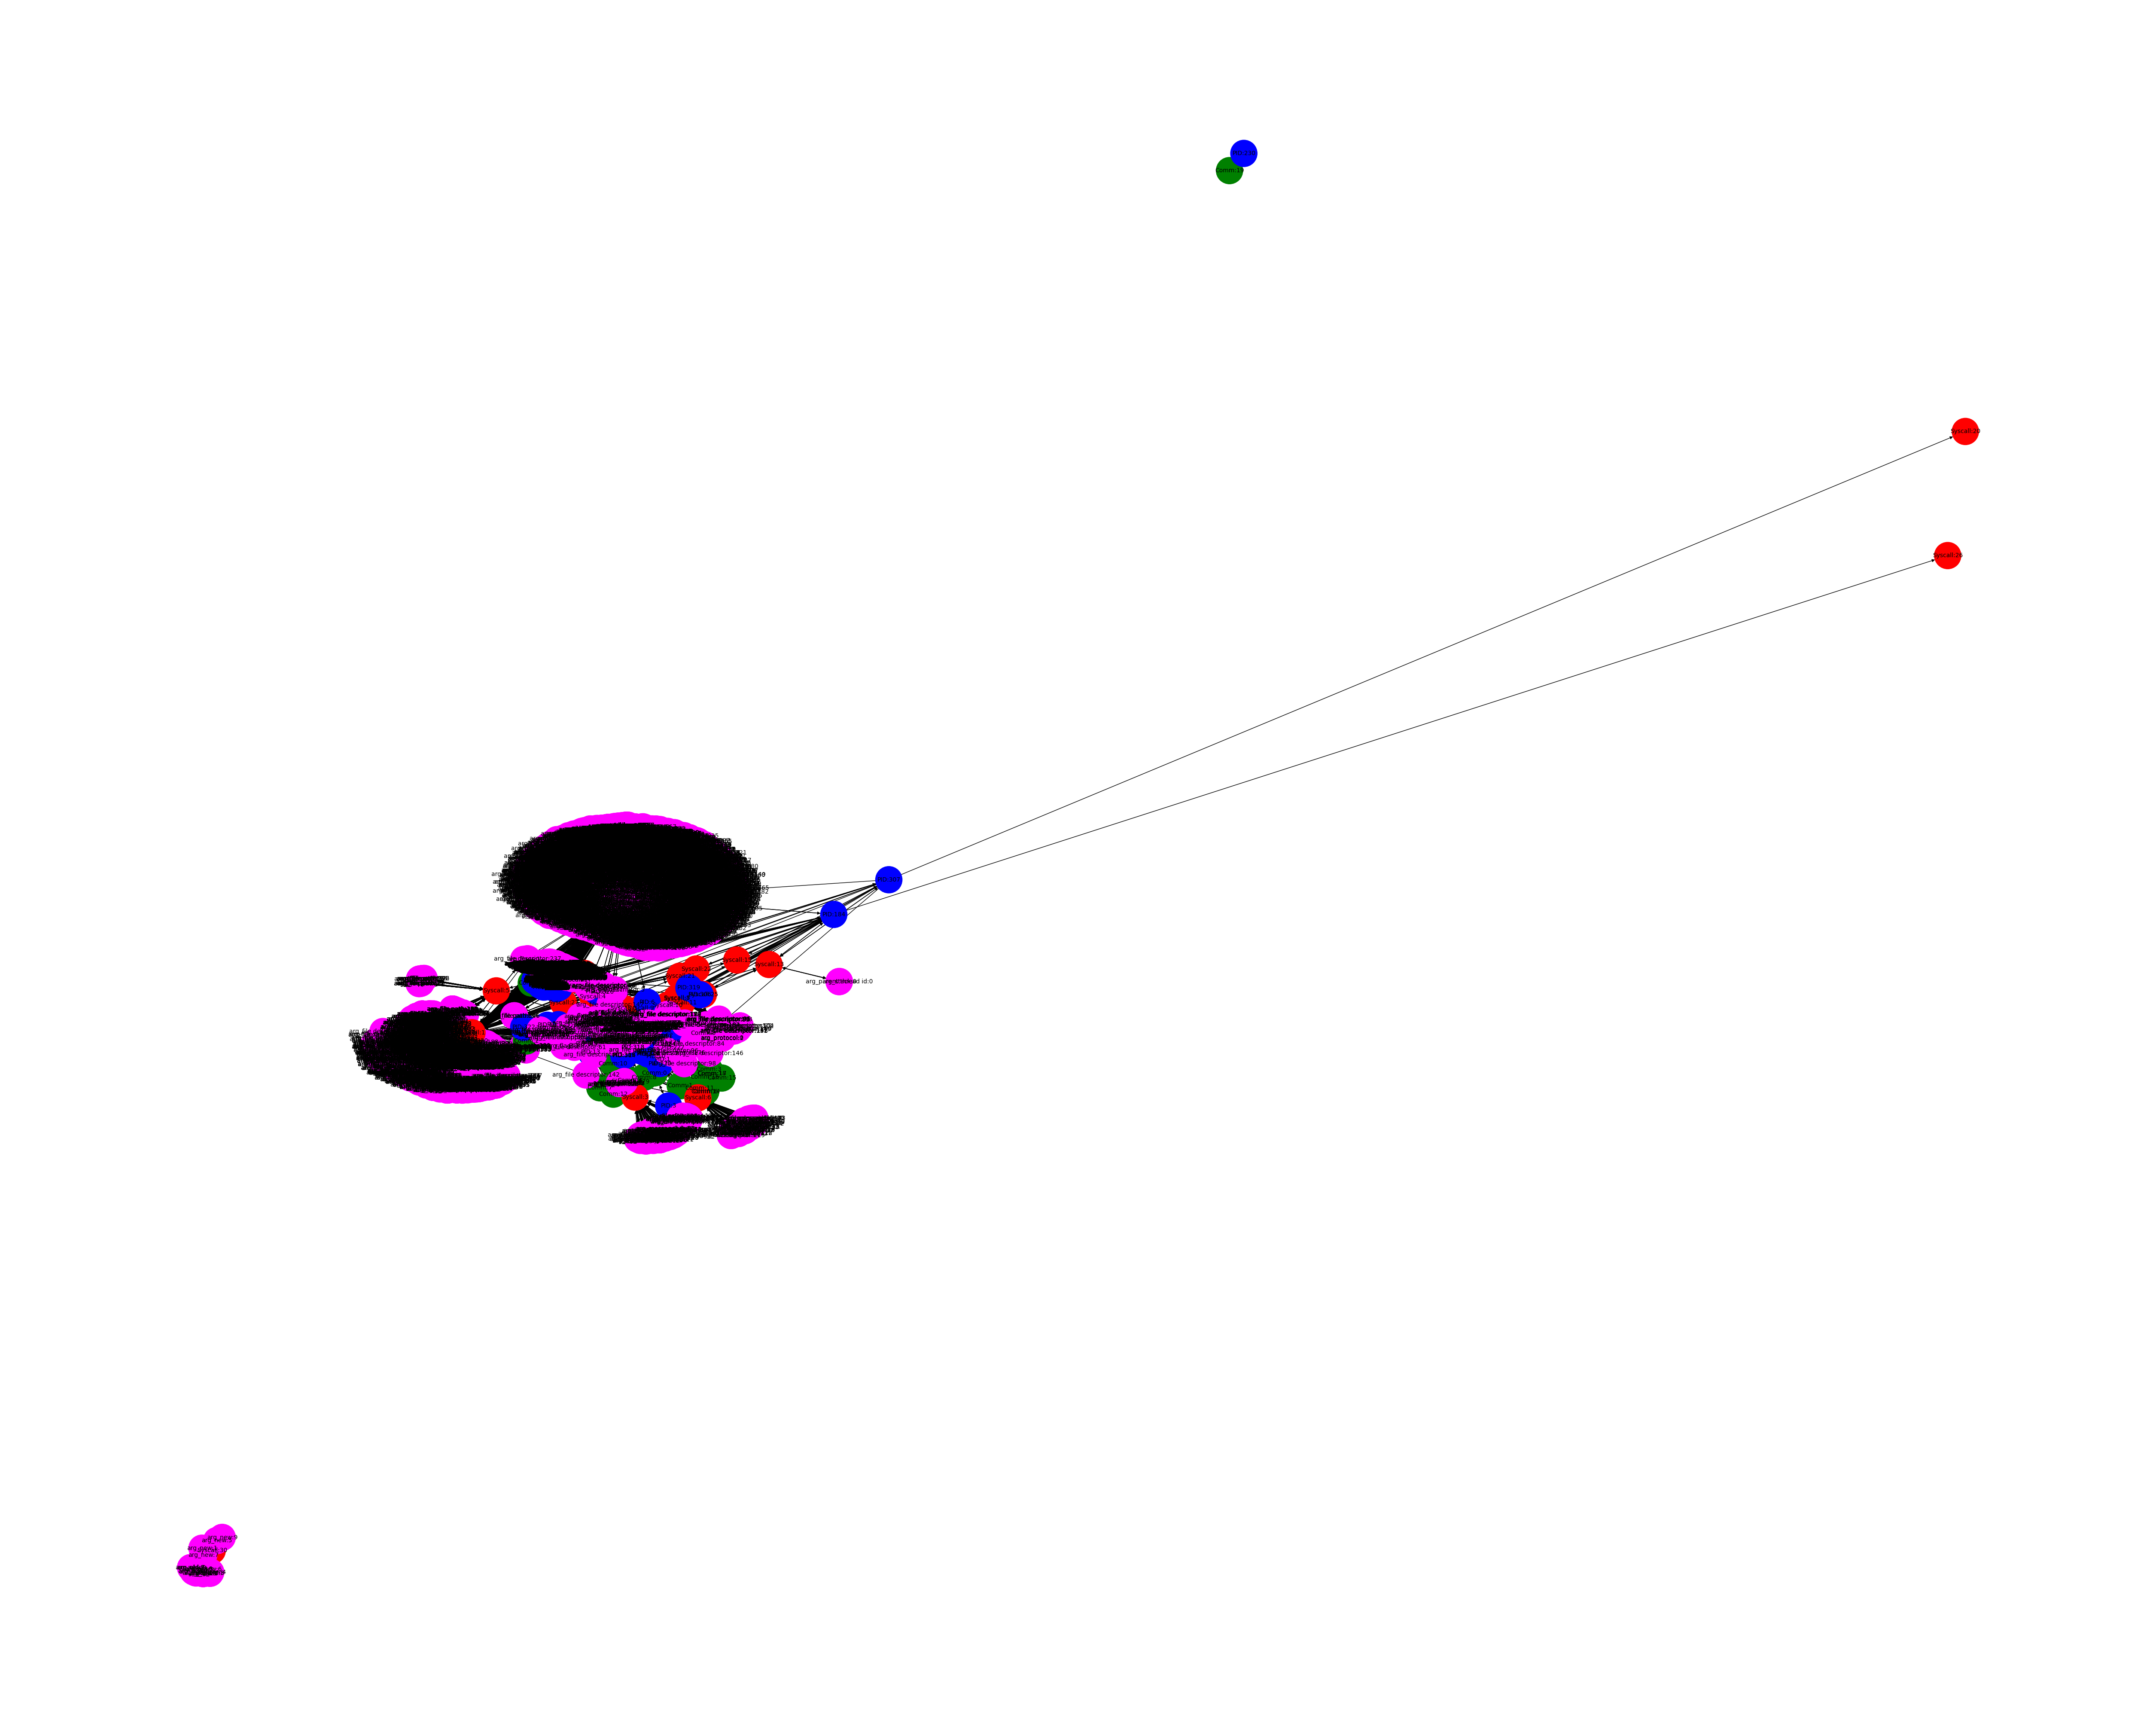

In [73]:
subg = dataset.preprocessed_expanded_subgraphs[200]
subg = HeteroDynamicGraph().from_heterodata(subg)
subg.visualize()